# **Chap 9：对抗和生成**

In [1]:
import tensorflow as tf
import numpy as np
from typing import Callable
from matplotlib import pyplot as plt
from source.code import utils
from source.code import ch9

2023-12-03 11:40:06.914338: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-03 11:40:07.083379: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-03 11:40:07.127550: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-03 11:40:07.725452: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [2]:
utils.gpu_limitation_config(memory=30,device=2)

## **9.3 生成对抗网络 GAN**

在通常的机器学习建模任务中，我们主要**围绕任务标签** $y$ 建模一个**判别模型** $f$（**Discriminative Model**），该模型可以刻画标签 $y$ 的分布（例如在二分类问题中，我们假设 $y$ 服从于一个参数为 $p$ 的伯努利分布 $y\sim \text{Bern}(p)$），每当拿到来自经验数据集的特征 $\mathbf{x}\in \mathcal{D}_x$ 后，便可以用 $f$ 做出预测 $f(\mathbf{x}) $

在另外一些场合，我们关心特征 $\mathbf{x}$ 的分布 $\mathcal{D}_x$，我们希望建立一个模型 $g$ 用来刻画分布 $\mathcal{D}_x$，**当 $g$ 能够很好地逼近真实分布 $\mathcal{D}_x$ 后，我们便能从 $g$ 的结果进行采样，来获得更多的输入样本**，我们将这样的模型 $g$ 称为**生成模型（Generative Model）**
* 例如，假设一组样本 $x_1,x_2,\cdots,x_N$ 抽样自分布 $N(\mu,\sigma^2)$，如果我们能够准确地估计出分布的参数 $\mu,\sigma$，我们就能够抽样得到更多来自相同分布的样本
* 在更复杂的场合，例如图像分类，RGB 图像 $\mathbf{x}$ 抽样自某个分布 $\mathcal{D}_x(\Theta)$，如果我们能够刻画分布 $\mathcal{D}_x(\Theta)$，从该分布中抽样得到更丰富的图像样本，这**在样本收集困难，样本收集成本高的场合**，用于扩张数据集非常有效

但在实际操作中，**对特征 $\mathbf{x}$ 分布的建模要比对标签建模困难得多**. 
* 从统计方法上，人们通常需要对分布 $\mathcal{D}_x$ 做分布假设，这对于非结构化的数据（图像、文本）不太容易实现
* 在分布的学习上，分布 $\mathcal{D}_x$ 的优化以及后续的预测阶段一般无法通过前向 / 反向传播高效计算，大部分方法都需要依靠贝叶斯统计，MCMC 等方法，这些方法的计算复杂度都很大

Goodfellow 等人基于纯粹的神经网络结构提出了**生成对抗网络（Generative Adversarail Nets，GAN）**，**GAN 具有清晰优美的建模逻辑，并继承了神经网络模型的前向 / 反向传播机制，克服了之前生成模型遇到的困难，在提出不久后很快成为生成模型的标杆**，后续涌现出各种基于 GAN 的改进工作，让 GAN 能够生成出让人惊讶的“赝品”，例如网站[This Person Dose Not Exist](https://thispersondoesnotexist.com/)，每刷新一下，网站就会基于 GAN 生成一张这个世界上并不存在的人的人像图片

----

### **9.3.1 生成器和判别器的博弈**

GAN 的框架非常清晰，**一个 GAN 模型包含两个组成部分，判别器模型 $D$ 和生成器模型 $G$**：
* 判别器 $D$ 判断一个给定的样本来自于真实的数据分布（标签为 1）还是来自于生成器 $G$ 的伪造（标签为 0），**这是个二分类问题**
* 生成器 $G$ 尝试生成尽可能接近真实数据分布的样本，避开判别器的检测
* 可以将生成器 $G$ 类比为造假钞的，它要逃脱判别器的追捕，而判别器 $D$ 类比为警察，要尽可能分辨假币和真币
* **生成器和判别器在这种对抗关系中，共同提升自己的能力**，$G$ 造假能力越来越强，$D$ 鉴别能力也越来越强
* **GAN 最终以判别器 $D$ 失效为收敛标志，这代表生成器 $G$ 能生存与真实数据分布完全一致的样本**

下面我们更准确地形式化 GAN 的建模和优化过程

假设生成器 $G$ 生成关于特征 $\mathbf{x}$ 的分布为 $p_g$，我们首先定义一个输入噪声变量的先验分布 $p_z(\mathbf{z})$，**生成器以噪声为输入，然后将其映射到特征 $\mathbf{x}$ 的分布**，即：
$$
G(\mathbf{z};\Theta_g) : \mathbf{z} \to \mathbf{x}
$$

我们可以讲 $G$ **设想为一个随机数生成器**，**它从噪声先验分布 $p_z$ 中采样作为自己的输入**，然后输出来自分布 $\mathcal{D}_x$ 的样本，$\mathbf{z}$ **就像随机数生成器的随机种子**，$\Theta_g$ 是生成器 $G$ 的参数，这取决于构造 $G$ 的神经网络结构，**整个 $G$ 被抽象为由 $\Theta_g$ 决定的一个可微函数**

判别器 $D$ 同样是一个神经网络，我们用 $D(\mathbf{x};\Theta_d)$ 表示，它负责将 $\mathbf{x}$ 映射到一个 $[0,1]$ 范围内的概率：
$$
D(\mathbf{x};\Theta_d) : \mathbf{x} \to [0,1]
$$

**概率值越趋近于 1，代表判别器 $D$ 认为样本 $\mathbf{x}$ 来自于真实分布 $\mathbf{D}_x$ 的可能性越大**，$\Theta_d$ 是判别器 $D$ 的参数，$D$ 同样被抽象为由 $\Theta_d$ 决定的一个可微函数

我们需要训练 $D$ 去**极大化其正确辨识样本 $\mathbf{x}$ 是来自于真实分布 $\mathcal{D}_x$ 还是来自于生成器 $G$ 的分布 $p_g$ 的概率**，同时，**为了愚弄判别器，我们需要训练 $G$ 去极小化置信度 $\log\left( 1 - D(G(\mathbf{z})) \right)$**，因此 **GAN 的优化目标是一个二人的 minimax 博弈**：
$$
\mathop{\min}\limits_{G} \mathop{\max}\limits_{D} V(D,G) = 
\mathbb{E}_{\mathbf{x}\sim \mathcal{D}_x} \left[ \log{ D(\mathbf{x} )}\right] + 
\mathbb{E}_{\mathbf{z}\sim p_z(\mathbf{z})} \left[ \log{\left(1 -  D(G(\mathbf{z}) ) \right)}\right]
$$

* **从判别器 $D$ 的视角**，为了极大化目标，它需要让 $D(\mathbf{x})$ 尽可能趋于 1，而**对伪造的样本，让 $D(G(\mathbf{z})$ 尽可能趋于 0**
* **从生成器 $G$ 的视角**，为了极小化目标，它**需要让 $D(G(\mathbf{z})$ 尽可能趋于 1**，从而蒙骗欺诈判别器 $D$，这就要求 $G$ 生成与分布 $\mathcal{D}_x$ 中尽可能相似的样本
* 生成器 $G$ 和判别器 $D$ **在优化 $D(G(\mathbf{z})$ 时的目标时相悖的，这就是 GAN 对抗的体现**

下图用一个正态分布的例子来说明 GAN 的训练过程，我们假设 $x$ 是标量服从于某个正态分布，而生成器 $G$ 需要负责将某个随机噪声分布 $z$ 变换到 $x$ 的分布
* GAN 会同时优化判别器 $D$ 的分布（**图中蓝色虚线**）和生成器 $G$ 的分布（**图中绿色实线**），图中从左到右代表了训练优化过程中的不同阶段
* 判别器 $D$ 输出 $[0,1]$ 概率以区分**真实分布（黑色虚线）的样本**和**来自生成器分布的伪造样本（绿色实线）**
* 在训练的初始阶段（图(a)），$D$ 和 $G$ 的分布都是随机生成的，判别器判别能力有限，生成器也完全没有伪造能力
* 训练判别器后（图(b)）后，**判别器能很好地区分两个分布，得到一条漂亮的 Sigmoid 曲线**
* 此时同时训练生成器（图(c)），**生成器 $G$ 伪造样本的分布 $p_g$ 会向着真实分布靠近 $\mathcal{D}_x$（绿色实线靠近黑色虚线）**
* 理想状态下 GAN 训练收敛阶段（图(d)），**生成器分布 $p_g$ 与真实分布 $\mathcal{D}_x$ 完全重合，判别器 $D$ 完全失去分辨能力（在 $x$ 分布支撑的任何位置，判别器输出的概率都等于 0.5）**

<img src="../source/Chap9/GAN的训练过程示意图.jpg" width=1200 style="display: block; margin-left: auto; margin-right: auto;">

在实践中，我们按照下面的 **GAN 算法**，通过数值迭代的方法优化 GAN 的生成器 $G$ 和判别器 $D$

<div style="border-top: 2px dashed red;"></div>

* **GAN 算法**（小批量随机梯度下降）
* 参数：训练迭代轮次 $N$，每一轮判别器迭代次数 $k$，批量大小 $m$
* **`for n = 1 to N`**
    * `# 判别器训练阶段`
    * **`for j = 1 to k`**   
        * 从噪声先验分布 $p_z$ 中采样 $m$ 个噪声样本 $\{\mathbf{z}^{(1)},\cdots,\mathbf{z}^{(m)}\}$
        * 从真实数据分布 $\mathcal{D}_x$ 中采样 $m$ 个样本 $\{\mathbf{x}^{(1)},\cdots,\mathbf{x}^{(m)}\}$
        * 用下面的梯度更新判别器 $D$：
            $$
            \nabla_{\Theta_d} \frac{1}{m}\sum_{i=1}^{m}\left[
                \log{D(\mathbf{x}^{(i)})} + \log{\left( 1 - D\left(G(\mathbf{z}^{(i)})\right) \right)}
            \right]
            $$
    * **`end for`**
    * `# 生成器训练阶段`
    * 从噪声先验分布 $p_z$ 中采样 $m$ 个噪声样本 $\{\mathbf{z}^{(1)},\cdots,\mathbf{z}^{(m)}\}$
    * 用下面的梯度更新生成器 $G$：
        $$
        \nabla_{\Theta_g} \frac{1}{m}\sum_{i=1}^{m}
            \log{\left( 1 - D\left(G(\mathbf{z}^{(i)})\right) \right)}
        $$
* **`end for`**

<div style="border-top: 2px dashed red;"></div>

下面分别就 GAN 的理论性质和实践进行补充说明

#### **9.3.1.1 GAN 理论性质**

生成器通过 $G(\mathbf{z})$ 导出了一个概率分布 $p_g$，我们期望档给定足够的训练后， GAN 算法 能够让 $p_g$ 收敛到一个 $\mathcal{D}_x$ 的良好估计，下面的讨论基于非参数模型，模型放置在概率密度函数空间中讨论，并假设模型都具有无限的学习能力

**Thm 1**：当生成器 $G$ 固定时，最优的判别器 $D$ 为：
$$
D_G^{*}(\mathbf{x}) = \frac{ p_{data}(\mathbf{x}) }{ p_{data}(\mathbf{x}) + p_g(\mathbf{x})}
$$
其中，$p_{data}$ 表示真实数据分布 $\mathcal{D}_x$ 导出的概率，$p_g$ 是生成器 $G(\mathbf{z})$ 导出的概率

**证明**：对于给定的任何生成器 $G$，对于前面所述的优化目标，**优化判别器 $D$ 等价于最大化价值函数 $V(G,D)$**：
$$
\newcommand{\arraystretch}{2}
\begin{array}{rcl}
V(G,D) & = & \displaystyle{ \int_\mathbf{x} {p_{data}(\mathbf{x})\log{D(\mathbf{x})} }dx + \int_\mathbf{z} {p_{z}(\mathbf{z})\log{\left( 1 - D(G(\mathbf{z})) \right)}dz } } \\
& = & \displaystyle{ \int_\mathbf{x} {p_{data}(\mathbf{x})\log{D(\mathbf{x})} + p_g(\mathbf{x})\log\left(1 - D(\mathbf{x}) \right) }dx  } 
\end{array}
$$

对于任意 $(a,b)\in \mathbb{R}^2  - \{0,0\}$，函数 $y\to a\log{y} + b\log{1- y}$ 在定义域 $y\in (0,1)$ 中的点 $y^* = a / (a+b)$ 处取得最大值，在概率空间中考虑支撑 $\text{Supp}(p_{data})\cup \text{Supp}(p_g)$，定理得证

<div style="border-top: 2px dashed blue;"></div>

注意到，**判别器 $D$ 的训练目标可以看作是极大化估计条件概率 $P(Y=y | \mathbf{x})$ 的对数似然**，其中 $Y$ 表示样本 $\mathbf{x}$ 是否来自于真实分布 $\mathcal{D}_x$，上面的极大极小博弈可以被重写为：

$$
\begin{array}{rcl}
C(G) & = & \mathop{\max}\limits_{D} V(D,G) \\
& = & \mathbb{E}_{\mathbf{x}\sim p_{data}}[\log D_G^*(\mathbf{x})] + \mathbb{E}_{\mathbf{z}\sim p_z}[\log(1-D_G^*(G(\mathbf{z})))] \\
& = & \mathbb{E}_{\mathbf{x}\sim p_{data}}[\log D(\mathbf{x})] + \mathbb{E}_{\mathbf{x}\sim p_g}[\log(1-D(\mathbf{x}))] \\
& = & \displaystyle{ \mathbb{E}_{\mathbf{x}\sim p_{data}} \left[\log \frac{p_{data}(\mathbf{x})}{p_{data}(\mathbf{x})+p_g(\mathbf{x})} \right] + \mathbb{E}_{\mathbf{x}\sim p_g} \left[\log \frac{p_g(\mathbf{x})}{p_{data}(\mathbf{x})+p_g(\mathbf{x})} \right] } \\
\end{array}
$$

**Thm 2**：训练优化目标 $C(G)$ 取到全局最小值当且仅当 $p_g = p_{data}$，此时，$C(G)$ 的最小值为 $-\log4$

**证明**：当 $p_g = p_{data}$ 时，$D_G^*(\mathbf{x}) = 0.5$，将结果带入 $C(G)$ 可得 $C(G) = \log{1/2} + \log{1/2} = -\log4 $，为了说明这是 $C(G)$ 能够取得的最小值，并且仅当 $p_g = p_{data}$ 时取到，注意到：
$$
\mathbb{E}_{\mathbf{x} \sim p_{data}}[-\log{2}] + \mathbb{E}_{\mathbf{x} \sim p_{g}}[-\log{2}] = -\log4
$$

并从 $C(G) = V(D_G^*,G)$ 中减去 $-\log4$ 重新分配，可得：
$$
C(G) = -log{4} + \text{KL}(p_{data}||\frac{p_{data}+p_g}{2}) + \text{KL}(p_g||\frac{p_{data}+p_g}{2})
$$

其中，$\text{KL}(p||q)$ 是分布 $p$ 和 $q$ 之间的 KL 散度，后面两个 KL 散度可以合并为 Jensen-Shannon 散度，即：
$$
C(G) = -log{4} + 2\text{JSD}(p_{data}||p_g)
$$

由于两个分布 $p,q$ 的 Jensen-Shannon 散度 $\text{JSD}(p||q)$ 是非负的，并且当且仅当 $p=q$ 时取到 0，因此 $C(G)$ 的最小值为 $-\log4$，并且当且仅当 $p_g = p_{data}$ 时取到，此时正好对应生成器 $G$ 导出的分布 $p_g$ 完美复刻了真实数据分布 $p_{data}$

<div style="border-top: 2px dashed blue;"></div>

最后，下面的 **定理 3** 描述了 GAN 迭代训练算法的收敛性

**Thm 3**：如果生成器 $G$ 和判别器 $D$ 都足够强，并且在 GAN 算法的每一步，判别器 $D$ 对于给定的 $G$ 都能取得其最优点，同时，$p_g$ 在更新过程中可以不断优化目标函数：
$$
\mathbb{E}_{\mathbf{x}\sim p_{data}}[\log D_G^*(\mathbf{x})] + \mathbb{E}_{\mathbf{x}\sim p_g}[\log(1-D_G^*(\mathbf{x}))]
$$

则 $p_g$ 可以收敛到 $p_{data}$

**证明**：考虑将 $V(G,D) = U(p_g, D)$ 作为 $p_g$ 的函数，注意到 $U(p_g,D)$ 是 $p_g$ 的凸函数，一个凸函数上确界的次梯度包含了函数在取得其极大值点处的梯度，形式化来说，
假设 $f(x) = \sup_{a\in A}f_a(x)$ 并且 $f_a(x)$ 对于每个 $a\in A$ 都是 $x$ 的凸函数，则 $\partial f_{\beta}(x) \in \partial f$，其中 $\beta = \arg\sup_{a\in A}f_a(x)$

现在来看给定生成器 $G$，在最优判别器 $D$ 处计算梯度，从而更新 $p_g$ 的过程，$\sup_{D}U(p_G,D)$ 是 $p_g$ 的凸函数，并且**Thm 2**说明了其具有唯一的全局最优值，因此在充分多次的迭代更新后，$p_g$ 最终可以收敛到 $p_{data}$

<div style="border-top: 2px dashed blue;"></div>

#### **9.3.1.2 GAN 实践**

在实际训练 GAN 时，**神经网络通过 $G(z;\Theta_g)$ 获得分布 $p_g$ 的一个有限的分布族表示，并且我们通过参数 $\Theta_g$ 进行优化而不是直接优化分布 $p_g$ 本身**，这使得深度学习中的优化框架都可以自然地使用. 我们可以用多层全连接网络来定义生成器 $G$，当然也可以设计其他结构的网络作为生成器，这在后面几节中介绍

另外一点，在训练过程中，想**通过一个循环阶段一次性完全优化好判别器 $D$ 在计算上不可行**，并且在有限的数据集上会**导致判别器 $D$ 过拟合**. 相反，我们在优化 $D$ 的 $k$ 步和优化 $G$ 的 1 步之间**交替进行**，只要**生成器 $G$ 变化足够缓慢**，这样做可以**使 $D$ 保持接近其最优解**

最后，实践中优化目标：
$$
\mathop{\min}\limits_{G} \mathop{\max}\limits_{D} V(D,G) = 
\mathbb{E}_{\mathbf{x}\sim \mathcal{D}_x} \left[ \log{ D(\mathbf{x} )}\right] + 
\mathbb{E}_{\mathbf{z}\sim p_z(\mathbf{z})} \left[ \log{\left(1 -  D(G(\mathbf{z}) ) \right)}\right]
$$

可能**无法为生成器 $G$ 的学习提供足够的梯度**，在学习的早期阶段，生成器 $G$ 的欺骗能力很弱，**判别器 $D$ 可以用很高的置信度识别出伪造样本**，这会使得 $1 - D(G(\mathbf{z})) \to 1$，进而 $\log\left( 1 - D(G(\mathbf{z})) \right) \to 0$ 趋于饱和（**从而梯度趋于 0**），因此训练 $G$ 去极小化 $\log\left( 1 - D(G(\mathbf{z})) \right) $，不如**训练 $G$ 去极大化 $\log\left(D(G(\mathbf{z})) \right)$**，优化目标更改后，会导出相同的优化方向，但却能够在训练早期为 $G$ 提供足够强壮的梯度信息

下面，我们以 MNIST 数据集为例，搭建一个简单的 GAN 模型来演示生成器 $G$ 和判别器 $D$ 的极大极小博弈过程

In [9]:
# 导入 MNIST 数据集，我们不需要测试集，也不需要标签
(x_train, _), _ = tf.keras.datasets.mnist.load_data()
# 变换数值类型并归一化
x_train = x_train.astype(np.float32) / 255.0
# 添加一个通道维度
x_train = np.expand_dims(x_train, axis=-1)
print(x_train.shape)

(60000, 28, 28, 1)


我们创建一个最简单的 CNN 来作为 GAN 的判别器 $D$

In [4]:
def create_mnist_discriminator():
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
        tf.keras.layers.Conv2D(8, 3, strides=2, padding='same', activation='relu'),
        tf.keras.layers.MaxPool2D(2),
        tf.keras.layers.Conv2D(16, 3, strides=2, padding='same', activation='relu'),
        tf.keras.layers.MaxPool2D(2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

In [6]:
discriminator = create_mnist_discriminator()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 14, 14, 8)         80        
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 7, 7, 8)          0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 4, 4, 16)          1168      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 2, 2, 16)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 32)               

我们**假设输入给生成器 $G$ 的噪声 $\mathbf{z}$ 先验分布是一个 64 维，均值为0，方差为 1 的多维高斯分布**，我们用多层全连接网络现将输入变换到 $28\times 28=784$ 维的输出，再将其变换形状到 `(28,28,1)`
* 因为**输入图像的像素值都被规范化到 $[0, 1]$，因此生成器的输出层使用 sigmoid 激活函数**

In [7]:
def normal_noise_generator(batch_size, noise_dim : int=64):
    return tf.random.normal(shape=(batch_size, noise_dim))

In [8]:
def create_mnist_generator(input_dims : int=64):
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(input_dims,)),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(28 * 28 * 1, activation='sigmoid'),
        tf.keras.layers.Reshape((28, 28, 1))
    ])
    return model

In [9]:
generator = create_mnist_generator()
generator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 256)               16640     
                                                                 
 dense_5 (Dense)             (None, 784)               201488    
                                                                 
 reshape (Reshape)           (None, 28, 28, 1)         0         
                                                                 
Total params: 218,128
Trainable params: 218,128
Non-trainable params: 0
_________________________________________________________________


接下来，针对判别器和生成器，我们定义两个目标函数 `gan_discriminator_loss()` 和 `gan_generator_loss()`

In [3]:
def gan_discriminator_loss(
    x_real : tf.Tensor, z_noise : tf.Tensor, D : tf.keras.Model, G : tf.keras.Model, **kwargs):
    """
    Parameters
    ----------
    x_real : tf.Tensor
        采样自真实数据的样本
    z_noise : tf.Tensor
        采样自噪声先验分布的样本
    D : tf.keras.Model
        判别器
    G : tf.keras.Model
        生成器
    """
    # 生成器生成样本
    x_fake = G(z_noise, **kwargs)

    # 真实样本和生成样本的标签
    y_true = tf.ones(shape=(x_real.shape[0], 1))
    y_fake = tf.zeros(shape=(x_fake.shape[0], 1))

    # 计算判别器损失
    loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(y_true, D(x_real, **kwargs))) + \
            tf.reduce_mean(tf.keras.losses.binary_crossentropy(y_fake, D(x_fake, **kwargs)))
    
    return loss

In [4]:
def gan_generator_loss(z_noise : tf.Tensor, D : tf.keras.Model, G : tf.keras.Model, **kwargs):
    """
    Parameters
    ----------
    z_noise : tf.Tensor
        采样自噪声先验分布的样本
    D : tf.keras.Model
        判别器
    G : tf.keras.Model
        生成器
    """
    # 生成器生成样本
    x_fake = G(z_noise, **kwargs)

    # 生成样本的标签
    y_fake = tf.ones(shape=(x_fake.shape[0], 1))

    # 计算生成器损失
    # 极小化 log(1 - D(G(z))) 等价于极大化 log(D(G(z)))
    # 极大化 log(D(G(z))) 等价于极小化 -log(D(G(z)))
    # 借用二分类交叉熵损失函数，将标签 y_fake 设为 1，等价于极小化 -log(D(G(z)))
    loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(y_fake, D(x_fake, **kwargs)))
    
    return loss

最后，我们来定义 GAN 的训练逻辑 `train_gan_model()`，整个梯度更新的过程和之前的神经网络没有太大区别，我们可以同 Tensorflow 的自动梯度实现，但需要注意下面几点：
* 在判别器 $D(\mathbf{x};\Theta_d)$ 训练阶段，我们只更新 $\Theta_d$，因此可以**冻结生成器**
* 在生成器 $G(\mathbf{z};\Theta_g)$ 训练阶段，我们只更新 $\Theta_g$，因此可以**冻结判别器**
* 判别器 $D$ 和生成器 $G$ 可以使用不同的优化器和不同学习率，注意**不能让生成器更新速度太快**，**GAN 训练动态系统需要判别器 $D$ 保持在其最优解附近**
* 在函数入参中，我们**多增加了一个参数 `beta_1`，用来控制 Adam 优化器中的动量项，这在后面 DCGAN 的内容中介绍**，这里可以忽略它

涉及到的相关函数均已经写入 `../source/code/ch9.py`

In [5]:
def train_gan_model(X : tf.Tensor, D : tf.keras.Model, G : tf.keras.Model, noise_prior : Callable,
                    Epochs : int=10000, k : int=5, batch_size : int=64, 
                    D_lr : float=1e-3, G_lr : float=1e-3, beta_1 : float=0.9, verbose : int=500):
    """
    Parameters
    ----------
    X : tf.Tensor
        真实数据集
    D, G : tf.keras.Model
        判别器和生成器
    noise_prior : Callable
        噪声先验分布
    Epochs : int, default=10000
        GAN 迭代次数
    k : int, default=5
        GAN 每轮迭代中判别器的迭代次数
    D_lr, G_lr : float
        判别器和生成器的学习率
    beta_1 : float, default=0.9
        Adam 优化器的 beta_1 动量项参数
    """

    # 优化器
    D_optimizer = tf.keras.optimizers.Adam(learning_rate=D_lr, beta_1=beta_1)
    G_optimizer = tf.keras.optimizers.Adam(learning_rate=G_lr, beta_1=beta_1)

    # 创建数据迭代器
    dataset = tf.data.Dataset.from_tensor_slices(X).batch(batch_size).shuffle(1000).repeat()
    iterator = iter(dataset)

    # 记录训练过程
    # 多增加一列，用于绘制生成样本
    animator = utils.Animator(xlabel='epoch', ylabel='loss', xlim=[1, Epochs], fmts=(('-',), ('m--',)),
                              legend=[("discriminator",), ("generator",)], figsize=(12,3), ncols=3)

    # 训练 GAN
    for epoch in range(Epochs):
        # 判别器训练阶段
        D.trainable, G.trainable = True, False # 判别器可训练，冻结生成器
        for _ in range(k):
            x_real = next(iterator) # 采样自真实数据
            z_noise = noise_prior(batch_size) # 采样自噪声先验分布
            with tf.GradientTape() as tape:
                D_loss = gan_discriminator_loss(x_real, z_noise, D, G, training=True)
            grads = tape.gradient(D_loss, D.trainable_variables)
            D_optimizer.apply_gradients(zip(grads, D.trainable_variables))
        
        # 生成器训练阶段
        D.trainable, G.trainable = False, True # 生成器可训练，冻结判别器
        z_noise = noise_prior(batch_size) # 采样自噪声先验分布
        with tf.GradientTape() as tape:
            G_loss = gan_generator_loss(z_noise, D, G, training=True)
        grads = tape.gradient(G_loss, G.trainable_variables)
        G_optimizer.apply_gradients(zip(grads, G.trainable_variables))

        # 绘制训练过程
        if epoch == 0 or (epoch + 1) % verbose == 0:
            # 绘制生成样本
            z_noise = noise_prior(1)
            x_fake = G(z_noise, training=False)
            animator.axes[2].cla()
            animator.axes[2].imshow(x_fake[0, :, :, 0], cmap='gray')
            animator.axes[2].axis('off')
            # 绘制损失
            animator.add(epoch + 1, (D_loss.numpy(),), ax=0)
            animator.add(epoch + 1, (G_loss.numpy(),), ax=1)

    return D, G

下面我们创建判别器和生成器，以及噪声先验，训练 GAN 模型
* **通常来说，GAN 模型需要大量的迭代次数才能获得比较好的生成效果**

In [7]:
# 创建判别器，生成器和噪声先验分布
noise_dims = 64
D, G = ch9.create_mnist_discriminator(), ch9.create_mnist_generator(input_dims=noise_dims)
noise_prior = lambda batch_size : ch9.normal_noise_generator(batch_size, noise_dims)

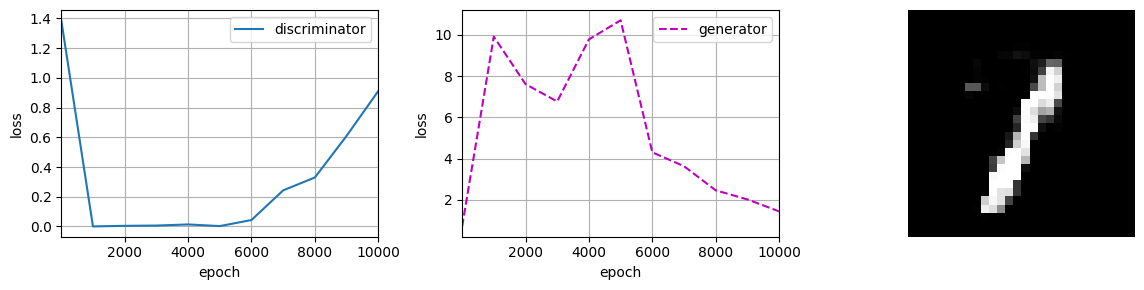

In [10]:
D, G = ch9.train_gan_model(x_train, D, G, noise_prior, 
                           Epochs=10000, k=3, batch_size=256, D_lr=1e-3, G_lr=1e-3, verbose=1000)

下面我们从噪声先验出发，绘制生成器 $G$ 伪造的 MNIST 图像

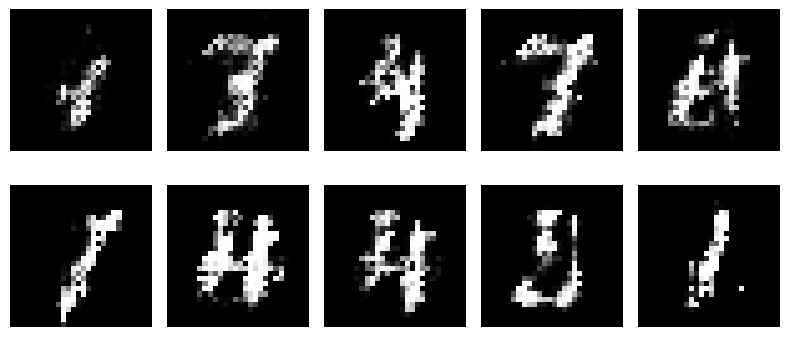

In [9]:
z_noise = noise_prior(10)
x_fake = G(z_noise)
# 绘制生成的手写数字
fig,ax = plt.subplots(2,5,figsize=(8, 4))
ax = ax.flatten()
for i in range(10):
    ax[i].imshow(x_fake[i].numpy().squeeze(), cmap='gray')
    ax[i].axis('off')
plt.tight_layout()

综合实验结果，我们可以得到：
* 从生成器和判别器的损失函数曲线，我们能够观察到 GAN 训练的不同阶段，以及**观察到生成器和判别器的对抗博弈**
* **GAN 的训练非常困难，非常不稳定**
    * 一方面，**GAN 相比其他模型需要大得多的迭代次数**
    * 此外，当生成器和判别器博弈时，损失下降变得不稳定，生成器并不能达到理想的收敛状态
    * 在实验中，**生成器甚至会出现“崩溃”的情况**，损失函数突然增大
* GAN 生成的图像的**缺乏多样性**，生成器为了愚弄判别器，可能**偏向于只生成几种简单的“稳健结果”**

由于训练 GAN 的过程是一个极大极小博弈，训练的困难是容易理解的
* 如果判别器 $D$ 迭代太弱，会导致 $G$ 可以非常轻易地愚弄判别器，阻碍生成器的学习
* 如果判别器 $D$ 迭代太强，会导致 $G$ 伪造样本无能为力，同样阻碍了生成器的学习

为了增强训练 GAN 的稳定性，并增加生成器 $G$ 生成结果的多样性，而不仅是生成几个稳健的简单样本，人们又从实践和理论上进行了探索，下面一节主要介绍 GAN 的两个重要改进工作：**DCGAN** 和 **WGAN**

----

### **9.3.2 GAN 的改进工作**

#### **9.3.2.1 DCGAN：Deep Convolutional GAN**

来自 Facebook AI 的 DCGAN 工作的主要贡献在于两方面：
* GAN 自发表以来，尝试复现 GAN 结果的研究者们发现，GAN 的训练非常困难，**DCGAN 尝试通过深度卷积来重新设计判别器和生成器的架构，以增加 GAN 训练的稳定性**
* 由于整个 GAN 的训练不需要图像标签，因此**这是一种无监督训练方法**（训练过程中只只需要图像的 0-1 真伪标签，而这个标签无关图像内容，因此无标注成本），DCGAN **将训练后的判别器 $D$ 作为图像的特征提取器，并尝试将其应用于分类任务，以证明 GAN 训练过程中能有效通过判别器 $D$ 提取图像中隐藏的语义特征**

在关于模型架构的具体改进上，DCGAN 通过实验得到以下三点（因此，**这是一个非理论性的结果，而属于工程探索的结果**）：
* 第一，**使用全卷积网络，而放弃使用池化层**，通过控制卷积的步幅，全卷积网络可以参数学习特有的下采样聚合逻辑，而不仅仅是最大池化（`MaxPool`）和平均池化（`AvgPool`），**全卷积网络同时用于生成器和判别器**，在**生成器中，可以用转置卷积实现上采样**
* 第二，**在卷积网络中逐渐放弃使用全连接层**，在图像分类领域，最先进的 CNN 模型都会使用全局平均池化代替 CNN 最后的全连接层，实验表明全局平均池化可以提升模型的稳定性
    * 对于生成器而言，**一维噪声先验先通过一个全连接层外加一个形状变换，投影到图像的多维张量**（通常是**低分辨率，但具有较多的通道**），然后通过**多个堆叠的转置卷积变换到高分辨率和指定通道数量**（**与 CNN 的顺序恰好相反，可以将这个过程视为卷积解码**）
    * 对于判别器而言，最后一层卷积的输出被拉直，然后送入单输出的 sigmoid 激活函数
* 第三，**使用 BatchNorm**，BatchNorm 通过归一化增强了模型的稳定性，解决了深度模型中的梯度流更新问题，实验表明 BatchNorm 为深度生成器提供了关键的提升，尤其是训练的早期，它**有效防止了生成器的崩坏**（这样生成器不会只收敛到单一样本，这是早期 GAN 生成样本缺乏多样性的核心问题）
    * 但如果**将 BatchNorm 应用于所有层，同样会导致模型振荡和不稳定**
    * 实验表明，**不要将 BatchNorm 应用到生成器的输出层和判别器的输入层**

此外，在激活函数的选择上，同样需要注意：
* 对于生成器，**除了输出层外，其他层均使用 ReLU 激活函数，输出层使用 Tanh 激活函数**（因此，图像像素值被归一化到 $[-1, 1]$），实验表明有界激活函数能帮助模型更快的学习，让输出覆盖整个训练分布的颜色空间
* 对于判别器，**实验发现使用 LeakyReLU 表现良好**，尤其对于高分辨率建模，相比其他激活函数能获得更稳定更好的效果

下面绘制了 LeakyReLU 的图像，LeakyReLU 和 ReLU 的区别在于 $x < 0$ 的部分，LeakyReLU 通过一个参数 $\alpha$ 控制 $x< 0$ 时线性变换的斜率，即：
$$
\text{LeakyReLU}(x) = \left\{
\begin{array}{ll}
x, & x \geq 0\\
\alpha\cdot x, & x < 0 \\
\end{array}
\right.
$$

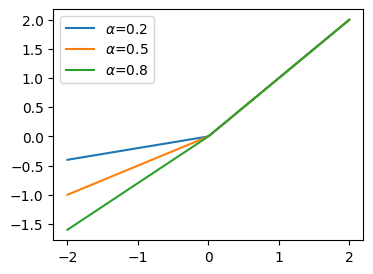

In [19]:
# 绘制 LeakyReLU 激活函数
x = tf.linspace(-2., 2., 100)
fig = plt.figure(figsize=(4, 3))
for alpha in [0.2, 0.5, 0.8]:
    plt.plot(x, tf.nn.leaky_relu(x, alpha=alpha), label=f'$\\alpha$={alpha:.1f}')
plt.legend()

在训练配置上，研究者们发现
* **学习率 $0.001$ 有些偏大**，可以使用更小的学习率例如 $0.0002$
* 如果使用 Adam 优化器，则**默认动量项 $\beta_1 = 0.9$ 太大，这会导致模型训练的振荡和不稳定**，可以讲动量项减小到 $\beta_1 = 0.5$

下面的两个函数 `create_dcgan_mnist_discriminator()` 和 `create_dcgan_mnist_generator()` 用于创建 DCGAN 所介绍的判别器和生成器架构
* 注意，**在 MNIST DCGAN 判别器的实现中，我们没有加入 BatchNorm**，因为 MNIST 数据集非常简单，**BatchNorm 的加入会使得判别器的学习收敛速度过快，导致生成器无法取得进展**，模型训练会崩坏

In [3]:
def create_dcgan_mnist_discriminator():
    def create_cnn_block(filters : int):
        block = tf.keras.Sequential([
            tf.keras.layers.Conv2D(filters, 3, padding='same'),
            tf.keras.layers.LeakyReLU(0.2),
            # 用卷积层代替池化层，进行下采样
            tf.keras.layers.Conv2D(filters, 3, strides=2, padding='same')
        ])
        return block
    
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
        create_cnn_block(8),
        tf.keras.layers.Dropout(0.5),
        create_cnn_block(16),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    return model

In [8]:
discriminator = create_dcgan_mnist_discriminator()
discriminator.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 14, 14, 8)         664       
                                                                 
 dropout_1 (Dropout)         (None, 14, 14, 8)         0         
                                                                 
 sequential_4 (Sequential)   (None, 7, 7, 16)          3488      
                                                                 
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 785       
                                                                 
Total params: 4,937
Trainable params: 4,937
Non-trainable params: 0
_________________________________________________________________


In [9]:
def create_dcgan_mnist_generator(input_dims : int=64):
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(input_dims,)),
        # 做一次投影变换，变换形状到 (7, 7, 128)
        tf.keras.layers.Dense(7 * 7 * 128, use_bias=False),
        tf.keras.layers.Reshape((7, 7, 128)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.ReLU(),
        # 先作用一层卷积，提升学习能力
        tf.keras.layers.Conv2D(64, 3, padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.ReLU(),
        # 用转置卷积进行上采样
        tf.keras.layers.Conv2DTranspose(64, 3, strides=2, padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Conv2DTranspose(1, 3, strides=2, padding='same', activation='tanh')
    ])
    return model

In [10]:
generator = create_dcgan_mnist_generator()
generator.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 6272)              401408    
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 batch_normalization (BatchN  (None, 7, 7, 128)        512       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 7, 7, 128)         0         
                                                                 
 conv2d_8 (Conv2D)           (None, 7, 7, 64)          73792     
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 64)         256       
 hNormalization)                                      

我们重新导入数据集，将像素值规范化到 $[-1, 1]$，然后训练模型

In [3]:
# 导入 MNIST 数据集，并归一化到 [-1, 1]
(x_train, _), _ = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype(np.float32) / 255.0 * 2.0 - 1.0
x_train = np.expand_dims(x_train, axis=-1)

In [5]:
# 创建判别器，生成器和噪声先验分布
noise_dims = 64
D, G = ch9.create_dcgan_mnist_discriminator(), ch9.create_dcgan_mnist_generator(input_dims=noise_dims)
noise_prior = lambda batch_size : ch9.normal_noise_generator(batch_size, noise_dims)

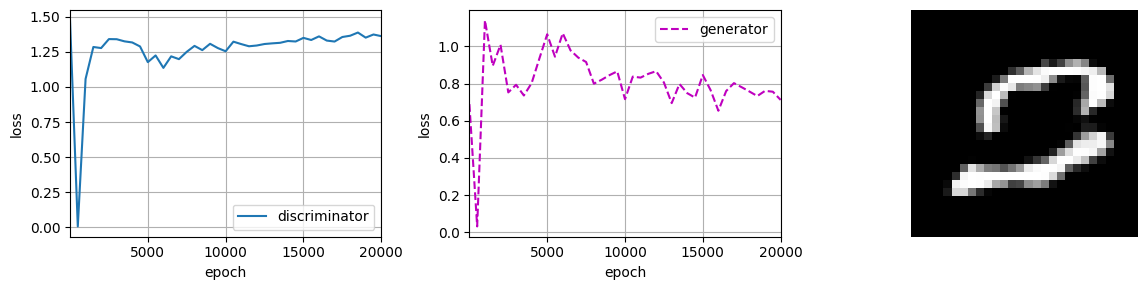

In [6]:
D, G = ch9.train_gan_model(x_train, D, G, noise_prior, 
                           Epochs=20000, k=5, batch_size=256, D_lr=2e-4, G_lr=2e-4, beta_1=0.5, verbose=500)

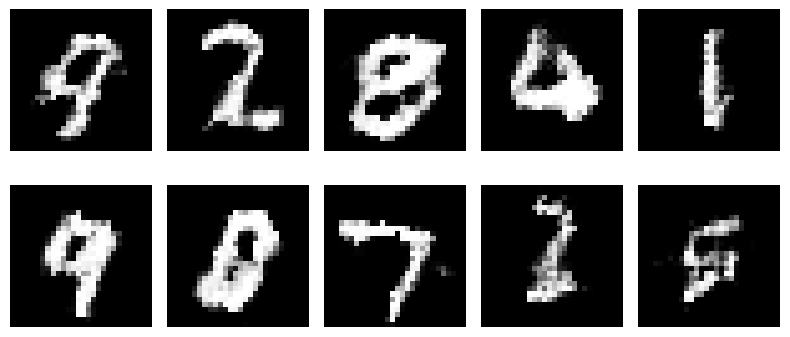

In [32]:
z_noise = noise_prior(10)
x_fake = G(z_noise)
fig,ax = plt.subplots(2,5,figsize=(8, 4))
ax = ax.flatten()
for i in range(10):
    ax[i].imshow(x_fake[i].numpy().squeeze(), cmap='gray')
    ax[i].axis('off')
plt.tight_layout()

#### **9.3.2.2 WGAN：Wasserstein GAN**

虽然 DCGAN 尝试从模型架构和工程实现上优化 GAN 训练不稳定的问题，但在实践中，两个问题亟待解决：
* 第一：**针对具体数据集，研究者们还是必须小心设计判别器和生成器的结构，以及仔细调整训练模型所使用到的超参数**（例如判别器的迭代次数 $k$，两个模型的学习率等），才能得到相对稳定的结果
* 第二：不像大部分神经网络，**GAN 训练过程中的损失无法体现训练的进展**，通常来说，损失越小越趋于平稳，模型趋于收敛，但这对 GAN 来说不适用

同样来自于 Facebook AI 团队的 **Wasserstein GAN（简称 WGAN）工作从理论上解释了 GAN 训练不稳定的原因**，并给出了改进方法，WGAN 的出现大幅提高了 GAN 训练的稳定性，GAN 本质上是利用生成器 $G$ 对真实数据分布建模，下面我们更深入讨论分布建模中的细节问题

为了对给定的概率分布建模，人们通常会定义一个参数化密度族 $(P_{\theta})_{\theta\in \mathbb{R}^d}$，然后利用收集到的数据 $\{x^{(i)}\}_{i=1}^{m}$ 最大化似然函数：
$$
\max_{\theta\in\mathbb{R}^d} \frac{1}{m}\sum_{i=1}^{m} \log{P_{\theta}(x^{(i)})}
$$

如果**真实数据的分布 $\mathbb{P}_r$ 具有概率密度**，**并且 $\mathbb{P}_\theta$ 是参数化密度 $P_\theta$ 对应的分布**，则渐进地，**最大化似然函数等价于极小化两个分布之间的 KL 散度 $\text{KL}(\mathbb{P}_r||\mathbb{P}_\theta)$**，为了使上面的优化成立，我们需要模型密度 $P_\theta$ 存在，然后，根据已有的研究成果，研究者们注意到：
* 在大部分场景中，我们所处理的**分布通常由一个低维的流形支撑**，在这种情况下，**模型流形和真实数据分布支撑之间很可能没有一个显著的交集**（或者说，二者几乎处处不相交）
* 进一步，**对于两个支撑几乎不相交的分布，KL 散度没有定义，或者简单地理解为 KL 散度为无穷**

在实践中，人们很少会直接估计真实分布 $\mathbb{P}_r$ 的密度（这个密度函数有可能不存在），而是定义一个从随机变量 $Z$ 到数据特征空间的映射 $g_{\theta}: \mathcal{Z}\to \mathcal{X}$（例如 GAN 中的生成器 $G$），$g_\theta$ 直接生成服从于分布 $\mathbb{P}_\theta$ 的样本，通过改变 $\theta$，我们就可以间接改变分布 $\mathbb{P}_\theta$ 使其靠近真实分布 $\mathbb{P}_r$，这么做有两个好处：
* 第一：我们**可以将所建模的分布限制在一个低维流行支撑上**（通过控制 $Z$ 的维度）
* 第二：**从 $g_\theta$ 中产生样本，相比获得真实数据密度函数的数值要容易得多**

GAN 就是上述建模中的一个典型代表，它通过优化 JS 散度来获得合适的参数 $\theta$，变分自编码（VAE）是另一种典型代表，我们在 **9.4** 当中介绍

因此，想要改进 GAN 的训练，我们就需要把注意力集中在**定义真实分布和模型分布之间距离的度量上**，即我们需要针对分布 $\mathbb{P}_\theta, \mathbb{P}_r$ 定义合适的距离或散度 $\rho(\mathbb{P}_\theta, \mathbb{P}_r)$
* 不同度量 $\rho$ 之间的**最基本差异是它们对于概率分布序列收敛性的影响**，分布序列 $(\mathbb{P}_t)_{t\in \mathbb{N}}$ 收敛当且仅当存在分布 $\mathbb{P}_\infty$ 使得 $\rho(\mathbb{P}_t, \mathbb{P}_\infty)$ 趋于 0，而收敛性取决于距离 $\rho$ 的定义
* 理论上，**一个距离 $\rho$ 如果让分布序列更容易收敛，则基于它导出的拓扑更弱**（或者更精确地说，当在 $\rho$ 下的收敛序列集是 $\rho'$ 下收敛序列集的超集时，由$\rho$ 导出的拓扑比由 $\rho'$ 导出的拓扑更弱）
* 此外，为了便于优化参数 $\theta$，我们希望**从参数到模型分布的映射 $\theta \to \mathbb{P}_\theta$ 是连续的**，连续性保证了当序列 $\theta_t$ 收敛到 $\theta$ 时，分布 $\mathbb{P}_{\theta_t}$ 也会收敛到分布 $\mathbb{P}_\theta$，然而，分布的收敛性依赖于我们如何定义分布之间的距离 $\rho$，**距离 $\rho$ 越弱，定义从 $\theta$ 参数空间到 $\mathbb{P}_\theta$ 分布空间的连续映射就越容易**，当 $\theta \to \mathbb{P}_\theta$ 是连续映射时，我们就可以定义一个损失函数 $\theta\to \rho(\mathbb{P}_\theta, \mathbb{P}_r)$，它关于 $\theta$ 是连续的

接下来，我们仔细讨论分布距离的定义问题，用 $\mathcal{X}$ 表示一个紧的度量集（例如图像像素空间 $[0,1]^d$），$\Sigma$ 表示 $\mathcal{X}$ 的所有 Borel 子集，$\text{Prob}(\mathcal{X})$ 表示定义在 $\mathcal{X}$ 上的概率度量空间，分布 $\mathbb{P}_r,\mathbb{P}_g\in \text{Prob}(\mathcal{X})$ 的距离和散度可以在此基础上定义：
* 总变差距离（Total Variation distance，TV）：
    $$
    \delta(\mathbb{P}_r,\mathbb{P}_g) = \mathop{\sup}\limits_{A\in \Sigma}|\mathbb{P}_r(A) - \mathbb{P}_g(A)|
    $$
* KL 散度（Kullback-Leibler divergence，KL）：
    $$
    \text{KL}(\mathbb{P}_r || \mathbb{P}_g) = \int{\log\left( \frac{P_r(x)}{P_g(x)} \right)} P_r(x) d\mu(x)
    $$

    其中，$\mu$ 是某个定义在 $\mathcal{X}$ 上的度量，**KL 散度是非对称散度**，当在支撑中存在点使得 $P_g(x) = 0, P_r(x) > 0$ 时，KL 散度可能是无穷的
* JS 散度（Jensen-Shannon divergence，JS）：
    $$
    \text{JS}(\mathbb{P}_r,\mathbb{P}_g) = \text{KL}(\mathbb{P}_r || \mathbb{P}_m) + \text{KL}(\mathbb{P}_g || \mathbb{P}_m)
    $$

    其中，$\mathbb{P}_m$ 是混合分布 $(\mathbb{P}_r + \mathbb{P}_g) / 2$，JS 散度是对称的
* **推土机距离**（Earth-Mover distance，EM）或 **Wasserstein-1 距离**：
    $$
    W(\mathbb{P}_r,\mathbb{P}_g) = \mathop{\inf}\limits_{\gamma \in \Pi(\mathbb{P}_r,\mathbb{P}_g)} \mathbb{E}_{(x,y)\sim \gamma} \left[  \|x-y\| \right]
    $$

    其中，**$\Pi(\mathbb{P}_r,\mathbb{P}_g)$ 表示边际密度分别是 $\mathbb{P}_r,\mathbb{P}_g$ 的所有联合分布 $\gamma(x,y)$ 的集合**，直觉上，$\mathbb{E}_{(x,y)\sim \gamma} \left[  \|x-y\| \right]$ 代表**为了将分布 $\mathbb{P}_r$ 变换到 $\mathbb{R}_g$，我们需要从 $x$ 到 $y$ 必须搬运多少“质量”**，因此，**EM 距离表示了两个分布进行最优传输计划的代价**

我们来通过一个具体的例子来熟悉这个陌生的 EM 距离，假设 $Z\sim U[0,1]$ 是单位区间上的均匀分布，用 $P_0$ 表示二维分布 $(0,Z)\in \mathbb{R}^2$（即第一个分量固定为 0，第二个分量是随机变量，它是一条经过原点且垂直于 $x$ 轴的线段），现在用 $g_\theta(z) = (\theta,z)$ 表示分布 $\mathbb{P}_\theta$，它具有单个参数 $\theta$，同样垂直于 $x$ 轴，在 $\theta \ne 0$ 时，由于两个分布的支撑不相交，不难计算出上述四种定义下，两个分布的距离：
* EM 距离，$W(\mathbb{P}_0,\mathbb{P}_\theta) = |\theta|$ 
* JS 散度：$\text{JS}(\mathbb{P}_0,\mathbb{P}_\theta) 
= \left\{
\begin{array}{ll}
\log2 & \theta\ne 0,\\
0 & \theta = 0
\end{array}
\right.
$
* KL 散度：$\text{KL}(\mathbb{P}_0 || \mathbb{P}_\theta) 
= \left\{
\begin{array}{ll}
+\infty & \theta\ne 0,\\
0 & \theta = 0
\end{array}
\right.
$
* TV 距离：$\delta(\mathbb{P}_0,\mathbb{P}_\theta) 
= \left\{
\begin{array}{ll}
1 & \theta\ne 0,\\
0 & \theta = 0
\end{array}
\right.
$

很容易注意到，当序列 $\theta_t\to 0$ 时，序列 $(\mathbb{P}_{\theta_t})$ 在 EM 距离下收敛到 $\mathbb{P}_0$，而在所有其他距离（JS，KL 和 TV）的度量下，该结论都不成立，**上面的例子很好地说明了基于 EM 距离，我们可以使用梯度下降在一个低维流形上优化分布，这在其他距离下无法完成，甚至待优化的目标函数是未定义的，不连续的**（例如在 JS 散度下，优化目标关于参数 $\theta$ 的导数为零，这是无用的），此外，上面的例子是一个**两个分布的支撑不相交时的优化示例，EM 距离也可以很好地解决这类问题，同样的结论也适用于两个分布支撑的非空交集是零测集的情况**

在适当条件下，我们能够保证 $W(\mathbb{P}_r,\mathbb{P}_\theta)$ 是关于参数 $\theta$ 的连续函数，定理如下

**Thm 4**：设 $\mathbb{P}_r$ 是 $\mathcal{X}$ 上的某个固定分布，$Z$ 是噪声先验空间 $\mathcal{Z}$ 中的随机变量，映射 $g: \mathcal{Z}\times \mathbb{R}^d \to \mathcal{X}$ 被记为 $g_\theta(z)$，其中 $z$ 作第一坐标表示噪声输入，$\theta$ 作第二坐标表示参数，用 $\mathbb{P}_\theta$ 表示 $g_\theta(z)$ 定义的分布，则：
1. 如果 $g$ 关于 $\theta$ 连续，则 $W(\mathbb{P}_r,\mathbb{P}_\theta)$ 也关于 $\theta$ 连续
2. 如果 $g$ 局部 Lipschitz 连续并且 Lipschitz 常数 $\mathbb{E}_z |L(\theta,z)| < \infty$，则 $W(\mathbb{P}_r,\mathbb{P}_\theta)$ 处处连续，并且导数几乎处处存在
3. **上面的两条性质对于 JS 散度和 KL 散度都不成立**

<div style="border-top: 2px dashed blue;"></div>

基于上述定理，关于 GAN 有下面的直接推论：

**Cor 1**：设 $g_\theta$ 是一个前向神经网络，用参数 $\theta$ 刻画，$p(z)$ 是一个噪声先验并且 $\mathbb{E}_{z\sim p(z)} [\|z\|] < \infty$（这对于高斯分布、均匀分布等成立），则 **Thm 4 中的 Lipschitz 条件成立**，进而 $W(\mathbb{P}_r,\mathbb{P}_\theta)$ 处处连续，且导数几乎处处存在

<div style="border-top: 2px dashed blue;"></div>

因此，EM 距离相比 JS 散度对于 GAN 来说是一种更合理的替代，使用 EM 距离作为优化目标能提供更稳定的梯度，让模型 $\mathbb{P}_\theta$ 的收敛更加容易，有关定理的证明和 EM 距离更多理论性质的讨论，可以阅读 [WGAN 论文](https://arxiv.org/abs/1701.07875)

接下来的问题是，**如何在 GAN 模型中计算 EM 距离，EM 距离定义中的下确界在计算中处理起来很棘手**，但根据 Kantorovich-Rubinstein 对偶性，我们有：
$$
W(\mathbb{P}_r, \mathbb{P}_\theta) = \mathop{\sup}\limits_{\|f\|_L \leq 1} \mathbb{E}_{x\sim \mathbb{P}_r}[f(x)] - \mathbb{E}_{x\sim \mathbb{P}_\theta}[f(x)]
$$

其中，**上确界针对所有 $1$-Lipschitz 函数 $f:\mathcal{X}\to \mathbb{R}$**，注意如果我们将条件换成 $\|f\|_L \leq 1$（即考虑 $K$-Lipschitz 条件，其中 $K$ 是常数），则这等价为考虑 $K\cdot W(\mathbb{P}_r, \mathbb{P}_\theta)$，因此，如果我们有一族参数化函数 $\{f_w\}_{w\in W}$ 均满足 $K$-Lipschitz 条件，则转而可以考虑下面优化问题：
$$
\mathop{\max}\limits_{w\in W} \mathbb{E}_{x\sim \mathbb{P}_r}[f_w(x)] - \mathbb{E}_{z\sim p(z)}[f_w(g_\theta(z))]
$$

如果上确界 $ \mathop{\sup}\limits_{\|f\|_L \leq 1} \mathbb{E}_{x\sim \mathbb{P}_r}[f(x)] - \mathbb{P}_{x\sim \mathbb{P}_\theta}[f(x)]
$ 对某些 $w\in W$ 可以取到（这是一个相当强的假设），则这个过程可以获得 $W(\mathbb{R}_r,\mathbb{R}_\theta)$ 的计算结果，除了前面的常数项不同，但这不影响优化，同时，我们可以考虑对 $W(\mathbb{R}_r,\mathbb{R}_\theta)$ 求导，用 $\mathbb{E}_{z\sim p(z)}[\nabla_\theta f_w(g_\theta(z))]$ 计算，虽然上面的讨论全基于直觉，但 WGAN 的作者证明了，在适当条件下，该过程是可靠的，接下来的问题是，如何找到 $ \mathop{\sup}\limits_{\|f\|_L \leq 1} \mathbb{E}_{x\sim \mathbb{P}_r}[f(x)] - \mathbb{P}_{x\sim \mathbb{E}_\theta}[f(x)]$ 中的函数 $f$

为了粗略地近似这个问题，我们**可以训练一个具有权重 $w$ 的参数化神经网络**，并且 $w$ 位于一个紧致空间 $W$ 中，然后通过 $\mathbb{E}_{z\sim p(z)}[\nabla_\theta f_w(g_\theta(z))]$ 进行反向传播，**就像经典 GAN 中所做的那样，那么 $f_w$ 就充当了 GAN 当中的判别器 $D$**，需要注意的是：
* 此时**判别器 $f_w$ 的最后一层不再需要 sigmoid 函数**，因为 **$f_w$ 的作用变为度量 EM 距离，而不是计算样本的真伪概率**，为了和 GAN 加以区分，研究者们将 WGAN 中的 $f_w$ 称为“**评估者**”（**critic**），而不是判别器
* $W$ 是紧致空间的条件意味着所有的函数 $f_w$ 都满足 $K$-Lipschitz 条件，其中 $K$ 仅依赖于 $W$ 而不依赖于具体的函数权重，为了使参数 $w$ 位于一个紧致空间中，我们可以简单地将权重固定在一个固定的范围内（比如 $W = [−0.01, 0.01]^{l}$），**在每次梯度更新之后进行参数裁剪**

算法 2 给出了 Wasserstein GAN 的过程

<div style="border-top: 2px dashed red;"></div>

* **WGAN 算法**（小批量随机梯度下降）
* 参数：学习率 $\alpha$，参数裁剪阈值 $c$，批量大小 $m$，判别器迭代次数 $k$，训练迭代次数 $N$
* **`for n = 1 to N`**
    * `# 评估者训练阶段`
    * **`for j = 1 to k`**   
        * 从噪声先验分布 $p_z$ 中采样 $m$ 个噪声样本 $\{\mathbf{z}^{(1)},\cdots,\mathbf{z}^{(m)}\}$
        * 从真实数据分布 $\mathcal{D}_x$ 中采样 $m$ 个样本 $\{\mathbf{x}^{(1)},\cdots,\mathbf{x}^{(m)}\}$
        * 用下面的梯度更新评估者，即 $f_w$（**极大化上确界目标，即极小化 EM 距离**）：
            $$
            \text{grad}_w = \nabla_w \left[
                \frac{1}{m} \sum_{i=1}^{m}f_w(\mathbf{x}^{(i)}) - \frac{1}{m}\sum_{i=1}^{m}f_w(g_\theta(\mathbf{z}^{(i)}))
            \right]
            $$
        * 更新 $w$：$w \leftarrow w + \alpha\cdot \text{RMSProp}(w, \text{grad}_w)$
        * 裁剪 $w$：$w \leftarrow \text{clip}(w,-c, c)$
    * **`end for`**
    * `# 生成器训练阶段`
    * 从噪声先验分布 $p_z$ 中采样 $m$ 个噪声样本 $\{\mathbf{z}^{(1)},\cdots,\mathbf{z}^{(m)}\}$
    * 用下面的梯度更新生成器，即 $g_\theta$（**极小化上确界目标，即极大化 EM 距离**）：
        $$
        \text{grad}_\theta = -\nabla_\theta \left[
            \frac{1}{m}\sum_{i=1}^{m} f_w(g_\theta(\mathbf{z}^{(i)}))
        \right]
        $$
    * 更新 $\theta$：$\theta \leftarrow \theta - \alpha\cdot \text{RMSProp}(\theta,g_\theta)$
* **`end for`**

<div style="border-top: 2px dashed red;"></div>

在 WGAN 的实现中，注意到下面几点：
* 使用权重裁剪去保持 Lipschitz 条件是一种糟糕的方式，如果裁剪阈值 $c$ 过大，则**需要非常长的时间才会让权重 $w$ 达到边界极限，从而让判别器训练到最优变得困难**；而如果 $c$ 过小，会**容易导致梯度消失**，但在 WGAN 的实验中，梯度裁剪表现出良好的性能，因此 WGAN 依然采用了参数裁剪
* 在 WGAN 中，**研究者在实验中发现带有动量的优化算法（例如 Adam）有可能会导致模型训练崩溃**，因此使用非动量优化算法，例如 RMSProp 优化器
* **对比原始 GAN 的模型架构和损失函数，实际编程中最主要的两个区别在于**：
    * 判别器 $D$ 或者说评估者 $f_w$ 的最后一层不使用 sigmoid
    * 因为评估者最后输出没有进行 sigmoid 变换得到概率，输出的是 logits，因此对比 GAN 的损失函数中，去掉了外层 log

最后，EM 距离是连续的和可微的，这意味着**我们可以训练判别器直到最优**
* 我们对判别器的训练越多，得到的 Wasserstein 梯度就越可靠，这在实践中很有用，因为 EM 距离几乎在任何地方都是可微的
* **而对于 JS 散度，随着判别器变得更好，梯度也会变得更可靠，但此时真实的梯度趋于 0**，因为 **JS 散度是局部饱和的**，此时就遇到了梯度消失问题，如前文中的关于平行线分布学习的例子
* 在下图中，我们给出了上述概念的一个直观展示，我们训练了一个 GAN 判别器和一个 WGAN 判别器，直到它们达到最优
    * GAN 判别器非常快速地学习区分真伪，并且**如预期的一样，判别器不提供可靠的梯度信息，梯度已经消失趋于 0**
    * 然而，**WGAN 判别器不会饱和，并收敛趋于一个线性函数，该函数在任何地方都给出了非常有效的梯度信息**，我们约束权重的条件（对应参数裁剪达到的 Lipschitz 条件）限制了函数在空间的不同部分最多为线性增长
    * 因此，**WGAN 的实质就是将原始 GAN 判别器 $D$ 对概率分布的优化（施加 sigmoid 变换，在训练中因为真伪样本支撑交集为零测集，判别器的 sigmoid 输出容易达到饱和区域，从而梯度趋于 0 无法提供有效的更新信息），转变为直接对 logits 的优化（去掉 sigmood 变换，直接优化 logits 能够保证梯度信息处处存在）**

一个更重要的事实是，**我们训练 WGAN 判别器直到最优时，不会遇到“模式坍缩”问题**，这是因为模式坍缩的原因在于，**对于固定的鉴别器来说，最优的生成器是根据鉴别器赋予最高值的点的一系列 $\delta$ 函数的总和**，有关模式坍缩的讨论参见习题，WGAN 作者指出在所有实验中，没有观察到 WGAN 出现模式坍缩的现象

<img src="../source/Chap9/WGAN的有效梯度.jpg" width=800 style="display: block; margin-left: auto; margin-right: auto;">

**因为 WGAN 算法试图在每次生成器更新之前相对良好地训练判别器 $f_w$，所以此时的损失函数可以作为 EM 距离的良好估计**，这使得 WGAN 训练过程中的损失可以较好地表示模型的进展，而不像传统的 GAN 一样，无法通过损失跟进模型的学习进展，下面，我们来实现 WGAN 算法

首先，我们定义 WGAN 的评论家 $f_w$

In [22]:
def create_wgan_mnist_critic():
    def create_cnn_block(filters : int):
        block = tf.keras.Sequential([
            tf.keras.layers.Conv2D(filters, 3, padding='same'),
            tf.keras.layers.LeakyReLU(0.2),
            # 用卷积层代替池化层，进行下采样
            tf.keras.layers.Conv2D(filters, 3, strides=2, padding='same')
        ])
        return block
    
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
        create_cnn_block(16),
        tf.keras.layers.Dropout(0.25),
        create_cnn_block(32),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1) # 最后一层不做 sigmoid 激活
    ])

    return model

WGAN 对生成器没有特殊要求，因此我们可以继续使用 DCGAN 的生成器，接下来是损失函数`wgan_critic_loss()` 和 `wgan_generator_loss()`

In [4]:
def wgan_critic_loss(
    x_real : tf.Tensor, z_noise : tf.Tensor, critic : tf.keras.Model, G : tf.keras.Model, **kwargs):
    """
    Parameters
    ----------
    x_real : tf.Tensor
        采样自真实数据的样本
    z_noise : tf.Tensor
        采样自噪声先验分布的样本
    cirtic : tf.keras.Model
        评估者
    G : tf.keras.Model
        生成器
    """
    # 生成器生成样本
    x_fake = G(z_noise, **kwargs)

    # 计算评估者损失
    loss = tf.reduce_mean(critic(x_real, **kwargs)) -\
              tf.reduce_mean(critic(x_fake, **kwargs))
    # 注意 cirtic 是极大化 EM distance，等价于极小化 -EM distance
    # 为了让所有优化器都是极小化损失，这里取负号
    loss = -loss

    return loss

In [34]:
def wgan_generator_loss(z_noise : tf.Tensor, critic : tf.keras.Model, G : tf.keras.Model, **kwargs):
    """
    Parameters
    ----------
    z_noise : tf.Tensor
        采样自噪声先验分布的样本
    cirtic : tf.keras.Model
        评估者
    G : tf.keras.Model
        生成器
    """
    # 生成器生成样本
    x_fake = G(z_noise, **kwargs)

    # 计算生成器损失
    loss = -tf.reduce_mean(critic(x_fake, **kwargs))
    
    return loss

最后，我们来定义 WGAN 训练函数，相较 GAN 的区别在于：
* **我们需要在每次评估者 $f_w$ 更新之后，对其进行参数裁剪，以保证 $f_w$ 被限制在一个紧致空间当中**
* 现在损失只需要绘制 EM 距离（即评估者 $f_w$ 的损失），EM 距离可以表征模型的学习进展

In [7]:
def train_wgan_model(X : tf.Tensor, critic : tf.keras.Model, G : tf.keras.Model, noise_prior : Callable,
                     c : float=0.01, k : int=5, Epochs : int=10000, batch_size : int=64, 
                     critic_lr : float=1e-4, G_lr : float=1e-4, verbose : int=500):
    """
    Parameters
    ----------
    X : tf.Tensor
        真实数据集
    critic, G : tf.keras.Model
        判别器和生成器
    noise_prior : Callable
        噪声先验分布
    c : float, default=0.01
        参数裁剪的阈值
    Epochs : int, default=10000
        WGAN 迭代次数
    k : int, default=5
        WGAN 每轮迭代中 cirtic 的迭代次数
    critic_lr, G_lr : float
        评估者和生成器的学习率
    """

    # 优化器
    critic_optim = tf.keras.optimizers.RMSprop(learning_rate=critic_lr)
    G_optim = tf.keras.optimizers.RMSprop(learning_rate=G_lr)

    # 创建数据迭代器
    dataset = tf.data.Dataset.from_tensor_slices(X).batch(batch_size).shuffle(1000).repeat()
    iterator = iter(dataset)

    # 记录训练过程
    # 多增加一列，用于绘制生成样本
    animator = utils.Animator(xlabel='epoch', ylabel='loss', xlim=[1, Epochs], fmts=(('-',), ),
                              legend=[("EM distance",), ], figsize=(7,3), ncols=2)

    # 训练 WGAN
    for epoch in range(Epochs):
        # 评估者训练阶段
        critic.trainable, G.trainable = True, False # 评估者可训练，冻结生成器
        for _ in range(k):
            x_real = next(iterator) # 采样自真实数据
            z_noise = noise_prior(batch_size) # 采样自噪声先验分布
            with tf.GradientTape() as tape:
                critic_loss = wgan_critic_loss(x_real, z_noise, critic, G, training=True)
            grads = tape.gradient(critic_loss, critic.trainable_variables)
            critic_optim.apply_gradients(zip(grads, critic.trainable_variables))

            # 参数裁剪
            for w in critic.trainable_weights:
                w.assign(tf.clip_by_value(w, -c, c))

        # 生成器训练阶段
        critic.trainable, G.trainable = False, True # 生成器可训练，冻结判别器
        z_noise = noise_prior(batch_size) # 采样自噪声先验分布
        with tf.GradientTape() as tape:
            G_loss = wgan_generator_loss(z_noise, critic, G, training=True)
        grads = tape.gradient(G_loss, G.trainable_variables)
        G_optim.apply_gradients(zip(grads, G.trainable_variables))

        # 绘制训练过程
        if epoch == 0 or (epoch + 1) % verbose == 0:
            # 绘制生成样本
            z_noise = noise_prior(1)
            x_fake = G(z_noise, training=False)
            animator.axes[1].cla()
            animator.axes[1].imshow(x_fake[0, :, :, 0], cmap='gray')
            animator.axes[1].axis('off')
            # 绘制损失
            animator.add(epoch + 1, (-critic_loss.numpy(),), ax=0)

    return critic, G

接下来，我们导入数据集，训练模型

In [10]:
# 导入 MNIST 数据集，并归一化到 [-1, 1]
(x_train, _), _ = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype(np.float32) / 255.0 * 2.0 - 1.0
x_train = np.expand_dims(x_train, axis=-1)

In [24]:
# 创建评估者，生成器和噪声先验分布
noise_dims = 64
critic, G = create_wgan_mnist_critic(), ch9.create_dcgan_mnist_generator(input_dims=noise_dims)
noise_prior = lambda batch_size : ch9.normal_noise_generator(batch_size, noise_dims)

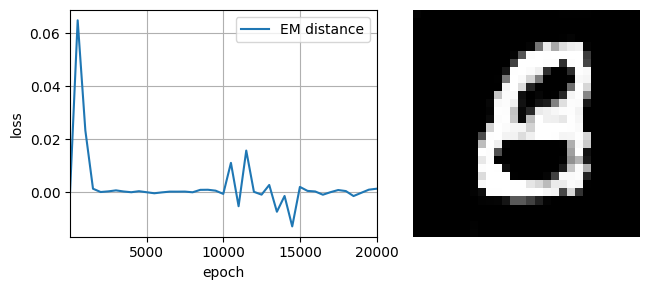

In [25]:
critic, G = train_wgan_model(x_train, critic, G, noise_prior, c=0.01,
                             Epochs=20000, k=3, batch_size=256, critic_lr=2e-4, G_lr=2e-4, verbose=500)

本章介绍的内容属于 GAN 的早期相关工作，有关 GAN 的改进还有一些后续的重要改进，例如将注意力机制引入的 SAGAN，和最新的可以根据人类意图作画的 DrugGAN

----

### **练习**

1. 最理想状况下，当模型完美收敛时，GAN 判别器 $D$ 的损失应该等于多少？

2. 在上面 DCGAN 的例子中，为判别器增加 BatchNorm 层，训练 GAN 模型，观察损失函数的变化情况以及生成器的输出
* **生成器输出收敛到一个相同结果的现象称为模型坍缩**（**mode collapse**）
* 尝试给出 GAN 模型坍缩产生的原因，可以查阅更多有关模型坍缩的讨论和资料

3. 尽管 WGAN 较原始 GAN 有所改进，但**实践中 WGAN 的训练仍然十分困难（😓），并且产生的图像质量并不比原始 GAN 更好**，我们继续**讨论基于 WGAN 的进一步改进**
    * 在有关 WGAN 理论部分的讨论中，我们已经明确过，在考虑两个分布 $\mathbb{P}_r$ 和 $\mathbb{P}_\theta$ 的支撑的低维流形时，**二者交集的测度为 0 的概率为 1**，因此，**在最优判别器下，最小化生成器等价于最小化 $\mathbb{P}_r$ 和 $\mathbb{P}_\theta$ 之间的 JS 散度，而此时 JS 散度都是常数 $\log 2$，导致更新生成器的梯度为 0**
    * 在 WGAN 中，作者指出**为了实现 Lipschitz 条件而进行的参数裁剪并不是一种理想的做法**，这会有两个缺点：
        * **(a) 网络容量不足**：当我们裁剪参数时，我们也限制了评估者的学习能力，这迫使 $f_w$ 只能学习简单特征，因此神经网络 $f_w$ 的大量参数容量未被充分利用
        * **(b) 梯度爆炸/消失**：参数裁剪阈值 $c$ 需要仔细调整，如果 $c$ 太大，评估者可能出现梯度爆炸，使其不受 Lipschitz 条件约束；而如果 $c$ 太小，则在深度网络中，容易出现梯度消失

        在实验中，作者观察到，**参数裁剪会将模型的参数推向两侧阈值 $-c, c$，而几乎没有参数会处于 $(-c,c)$ 之间**
    * 一种新的解决思路是使用**梯度惩罚**（**Gradient Penalty，GP**）替代 Lipschizt 约束，我们在评估者的损失中添加下面一项：
        $$
        \text{GP} = \lambda\cdot \mathbb{E}_{\tilde{\mathbf{x}}\sim \mathbb{P}_{mix}}\left[
            \left(\| \nabla_{\tilde{\mathbf{x}}} f_w(\tilde{\mathbf{x}}) \|_2 - 1\right)^2
        \right]
        $$

        这依托于如下的**定理**：
        
        <div style="border-top: 2px dashed blue;"></div>

        **定理**：设 $\mathbb{P}_r, \mathbb{P}_g$ 是紧致空间 $\mathcal{X}$ 中的两个分布，则存在 Lipschitz 函数 $f^*$，它是 WGAN 优化目标 $\max_{\|f\|_L \leq 1} \mathbb{E}_{y\sim \mathbb{P}_r}[f(y)] - \mathbb{E}_{x\sim \mathbb{P}_g}[f(x)]$ 的最优解，设 $\pi$ 是 $\mathbb{P}_r,\mathbb{P}_g$ 的最优连接函数，它极小化：
        $$
        W(\mathbb{P}_r, \mathbb{P}_g) = \inf_{\pi \sim |Pi(\mathbb{P}_r,\mathbb{P}_g)} \mathbb{E}_{(x,y)\sim \pi}[\|x - y\|]
        $$

        其中，$|Pi(\mathbb{P}_r,\mathbb{P}_g)$ 是边缘分布分别是 $\mathbb{P}_r,\mathbb{P}_g$ 的联合分布 $\pi(x,y)$ 的结合，如果 $f^*$ 可微，$\pi(x = y) = 0$，设 $x_t = tx + (1- t)y, 0\let t\leq 1$，则：
        $$
        \mathbb{P}_{(x,y)\sim \pi}\left[
            \nabla f^*(x_t) = \frac{y - x_t}{\|y - x_t\|}
        \right] = 1
        $$

        定理有一个非常简单的推论，**即 $f^*$ 在 $\mathbb{P}_r,\mathbb{P}_g$ 的几乎任何地方都有范数为 1 的梯度**
        
        <div style="border-top: 2px dashed blue;"></div>
        
        * **$\mathbb{P}_{mix}$ 是 $\mathbb{P}_r$ 和 $\mathbb{P}_\theta$ 的混合分布，这通过对两个分布样本的插值实现**，假设单样本 $\mathbf{x}_{real}\sim \mathbb{P}_r, \mathbf{x}_{fake}\sim \mathbb{P}_\theta$，我们从 $[0,1]$ 均匀分布中采样 $\mathbf{\epsilon} \sim U[0,1]$，则混合样本 $\tilde{\mathbf{x}}$ 为：
        $$
        \tilde{\mathbf{x}} = \mathbf{\epsilon}\cdot \mathbf{x}_{real} + (1 - \mathbf{\epsilon})\cdot \mathbf{x}_{fake}
        $$ 
        * $\|x\|_2$ 是通常的 $L^2$ 范数，梯度惩罚要求梯度 $\| \nabla_{\tilde{\mathbf{x}}} f_w(\tilde{\mathbf{x}}) \|_2$ 趋于 1，**这使得评估者的学习速度在一定受限范围内是自由的**，这防止了梯度消失和梯度爆炸的出现，注意**这是一个双侧惩罚**（即我们不仅是要求 $\| \nabla_{\tilde{\mathbf{x}}} f_w(\tilde{\mathbf{x}}) \|_2 < 1$，从经验上看，这似乎并没有过多地约束评估者，在**梯度惩罚 GP 的理论中，评估者 $f_w$ 在 $\mathbb{P}_r, \mathbb{P}_\theta$ 下的几乎所有地方以及两者之间的大部分区域都有范数等于 1 的梯度**，在实践中，双侧惩罚效果稍好）
        * 从另一个角度，GP 惩罚项利用混合分布 $\mathbb{P}_{mix}$，**直观上使得原本的两个低维流形“弥散”到整个高维空间，强行让它们产生不可忽略的交集**。而一旦存在分布之间有重叠，判别器（或者说评估者）就不那么容易将真伪样本区分开，**这种混合两个分布的技巧对于稳定梯度很有帮助，即使对于原始 GAN 模型的 JS 散度，也能提升训练的稳定性**
    * 以上引入梯度惩罚的模型称为 WGAN-GP，最后，相比 WGAN，在实现 WGAN-GP 时，还需要注意以下两点：
        * **在 WGAN 的基础上去掉参数裁剪**
        * **在评估者 $f_w$ 中不要使用 BatchNorm**，在大部分神经网络模型中，BatchNorm 的加入可以提升训练稳定性，但是 BatchNorm 会改变评估者 $f_w$ 问题的形式（**从单一输入单一输出，变为批量输入批量输出**），但 **GP 的梯度惩罚在 BatchNorm 的设定下无效，因为 GP 是对评估者考虑的每个样本梯度做独立惩罚，而不是整个批量**，为此，我们可以简单地去除掉评估者架构中的 BatchNorm，**GP 适用于不引入样本之间相关性的规范化方法**（例如，**在实践中，可以将评估者中的 BatchNorm 替换为 LayerNorm**）

根据上述的介绍和讨论，实现 WGAN-GP，你需要实现的包含三个部分：
* WGAN-GP 的评估者 $f_w$
* 带有 GP 的评估者的损失函数
* WGAN-GP 的训练逻辑

然后，在 FASHION-MNIST 数据集上训练 WGAN-GP 模型，超参数的配置可以参考如下：
* 每轮迭代评估者训练次数 `k = 3` 或者 `k = 5`
* GP 惩罚的权重 `lambd = 10`
* 评估者和生成器的学习率 `lr = 0.0001`
* 评估者建议不要用带动量的优化器，或者使用 Adam 并设置动量项系数为 0，生成器可以使用动量优化器

参考代码可以见 `../source/code/ch9.py` 中的 `create_wgan_gp_fashion_mnist_critic()`，`wgan_gp_critic_loss()`，`train_wgan_gp_model()`

----